# Final Project: Image Classification on Imbalanced Dataset

Nick Jenkins

06/10/2022

EE 443, University of Washington

Image classification on an imbalanced dataset is an important problem in a real-world scenario. Throughout this final project is a study of Long-Tailed Recognition (LTR). LTR is learning (training) from long-tail distributed (imbalanced) training data and evaluating the classification accuracy over a balanced test set.

**Objectives**


*   Balanced image classification on the balanced CIFAR-60 set using a classical CNN
*   Imbalanced image classification on the imbalanced CIFAR-60 set with different ratios
*   Method design and implementation: propose and implment methodology (network architectures, training strategies, loss functions, etc.)
*   Experiment design and analysis: do different experiments to prove performance and effectiveness
*   Presentation and writing skills


**Requirements**

*   Achieve good classification accuracy on the balanced testing datasets among the following training datasets: CIFAR-60-LT (p = 1, 0.1, 0.02, 0.005) using the proposed methods.
*   Allowed to use papers and open-source code, but must describe methods and modifications. Novelty of proposed method will impact grade.



## Set-up

In [5]:
# import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as utils

from torchsummary import summary

import matplotlib.pyplot as plt
from matplotlib import cm

import numpy as np

import os
import json
import cv2

# mount drive
from google.colab import drive
drive.mount('/content/gdrive')

# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
cuda:0


In [ ]:
!unzip /content/gdrive/MyDrive/'EE 443'/Final/cifar-data.zip -d ./cifar-data

Streaming output truncated to the last 5000 lines.
  inflating: ./cifar-data/cifar-100-data/converted60/cifar60/images/pine_tree/train_29013.jpg  
  inflating: ./cifar-data/cifar-100-data/converted60/cifar60/images/pine_tree/train_28902.jpg  
  inflating: ./cifar-data/cifar-100-data/converted60/cifar60/images/pine_tree/train_28889.jpg  
  inflating: ./cifar-data/cifar-100-data/converted60/cifar60/images/pine_tree/train_28838.jpg  
  inflating: ./cifar-data/cifar-100-data/converted60/cifar60/images/pine_tree/train_28789.jpg  
  inflating: ./cifar-data/cifar-100-data/converted60/cifar60/images/pine_tree/train_28697.jpg  
  inflating: ./cifar-data/cifar-100-data/converted60/cifar60/images/pine_tree/train_28612.jpg  
  inflating: ./cifar-data/cifar-100-data/converted60/cifar60/images/pine_tree/train_28578.jpg  
  inflating: ./cifar-data/cifar-100-data/converted60/cifar60/images/pine_tree/train_28575.jpg  
  inflating: ./cifar-data/cifar-100-data/converted60/cifar60/images/pine_tree/train_2

In [ ]:
classes = ['apple', 'baby', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'boy', 'bus', 'butterfly', 
                 'camel', 'can', 'caterpillar', 'cattle', 'chair', 'clock', 'cloud', 'cockroach', 'couch', 'crab',
                 'dinosaur', 'fox', 'lamp', 'lawn mower', 'lobster', 'man', 'maple tree', 'mouse', 'oak tree', 'orange',
                 'otter', 'palm tree', 'pear', 'pickup truck', 'pine tree', 'plate', 'poppy', 'porcupine', 'possum',
                 'rabbit', 'ray', 'road', 'rocket', 'seal', 'shark', 'skunk', 'skyscraper', 'snake', 'spider', 'streetcar',
                 'table', 'telephone', 'television', 'tiger', 'turtle', 'whale', 'willow tree', 'woman', 'worm']

In [ ]:
def get_cifar_dicts(data_dir, json_name):
    dataset_dicts = []

    thing_classes = ['apple', 'baby', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'boy', 'bus', 'butterfly', 
                 'camel', 'can', 'caterpillar', 'cattle', 'chair', 'clock', 'cloud', 'cockroach', 'couch', 'crab',
                 'dinosaur', 'fox', 'lamp', 'lawn_mower', 'lobster', 'man', 'maple_tree', 'mouse', 'oak_tree', 'orange',
                 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plate', 'poppy', 'porcupine', 'possum',
                 'rabbit', 'ray', 'road', 'rocket', 'seal', 'shark', 'skunk', 'skyscraper', 'snake', 'spider', 'streetcar',
                 'table', 'telephone', 'television', 'tiger', 'turtle', 'whale', 'willow_tree', 'woman', 'worm']

    ann = json.load(open(os.path.join(data_dir, json_name)))['annotations']

    for a in ann:
        value = thing_classes.index(a['category'])
        img = np.transpose((cv2.imread(os.path.join('cifar-data/', a['fpath']))), (2,0,1))
        record = [img, value]
        dataset_dicts.append(record)
    return dataset_dicts

In [8]:
# number of works for dataloader
workers = 2

# batch size for training
bat_sz = 64

# learning rate
lr = 0.001

## Balanced Image Classification on the CIFAR-60 set

### Loading the dataset

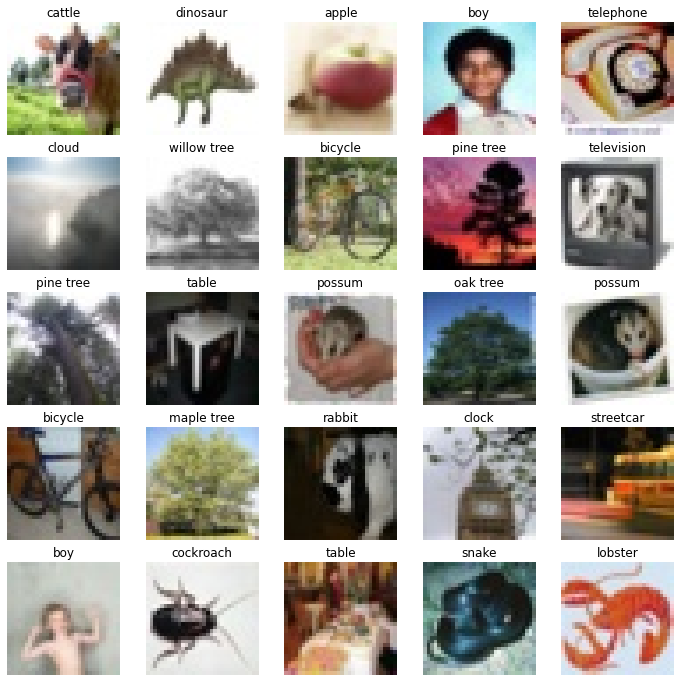

In [ ]:
# directory for dataset
dataroot = './cifar-data/cifar-100-data/converted60/cifar60/'

train_data = get_cifar_dicts(dataroot, 'cifar60_train.json')
test_data = get_cifar_dicts(dataroot, 'cifar60_test.json')

train_loader = torch.utils.data.DataLoader(train_data, batch_size=bat_sz, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle = True)

fig, axs = plt.subplots(5, 5, figsize = (12, 12))

for i, ax in enumerate(axs.flat):
  ax.imshow(cv2.cvtColor(np.transpose(train_data[i][0],(1, 2, 0)), cv2.COLOR_BGR2RGB))
  ax.axis('off')
  ax.set_title(classes[train_data[i][1]])

# fig.savefig("/content/gdrive/MyDrive/EE 443/Final/figs/cifar60.png")

### Basic CNN
Acc: 28.73%

In [6]:
class basicCNN(nn.Module):
    def __init__(self):
        super(basicCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 60)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [9]:
basic_cnn = basicCNN().to(device)
summary(basic_cnn, (3, 32, 32))

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(basic_cnn.parameters(), lr=lr, momentum=0.9)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 30, 30]             168
            Conv2d-2           [-1, 16, 13, 13]             880
            Linear-3                  [-1, 120]          69,240
            Linear-4                   [-1, 84]          10,164
            Linear-5                   [-1, 60]           5,100
Total params: 85,552
Trainable params: 85,552
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.33
Estimated Total Size (MB): 0.40
----------------------------------------------------------------


In [ ]:
n_epoch = 25
acc = 0

basic_cnn.train()
for epoch in range(n_epoch):  # loop over the dataset multiple times
    for i, data in enumerate(train_loader, 0):
        input = data[0].to(device).float()
        label = data[1].to(device)
        optimizer.zero_grad()

        output = basic_cnn(input)

        loss = criterion(output, label)
        loss.backward()

        optimizer.step()
        pass
    corr = 0
    num = 0
    basic_cnn.eval()
    with torch.no_grad():
        for data in test_loader:
            input = data[0].to(device).float()
            target = data[1].to(device)

            output = basic_cnn(input)
            output = output.argmax()

            if output == target[0]:
                corr += 1
            num += 1
            pass
    epoch_acc = corr/num*100
    print("Accuracy of the model (epoch {}) is: {}%".format(epoch, epoch_acc))
    if (epoch_acc > acc):
        acc = epoch_acc
        PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60_basic.pth'
        torch.save(basic_cnn.state_dict(), PATH)
    basic_cnn.train()

Accuracy of the model (epoch 0) is: 4.583333333333333%
Accuracy of the model (epoch 1) is: 11.983333333333333%
Accuracy of the model (epoch 2) is: 17.133333333333333%
Accuracy of the model (epoch 3) is: 20.533333333333335%
Accuracy of the model (epoch 4) is: 23.683333333333334%
Accuracy of the model (epoch 5) is: 24.55%
Accuracy of the model (epoch 6) is: 24.883333333333333%
Accuracy of the model (epoch 7) is: 26.116666666666667%
Accuracy of the model (epoch 8) is: 27.516666666666666%
Accuracy of the model (epoch 9) is: 26.966666666666665%
Accuracy of the model (epoch 10) is: 27.23333333333333%
Accuracy of the model (epoch 11) is: 26.816666666666666%
Accuracy of the model (epoch 12) is: 28.199999999999996%
Accuracy of the model (epoch 13) is: 27.616666666666667%
Accuracy of the model (epoch 14) is: 25.766666666666666%
Accuracy of the model (epoch 15) is: 27.416666666666668%
Accuracy of the model (epoch 16) is: 28.733333333333334%
Accuracy of the model (epoch 17) is: 28.433333333333334%

In [ ]:
# loading best model
PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60_basic.pth'
basic_cnn = basicCNN().to(device)
basic_cnn.load_state_dict(torch.load(PATH))
print('Best model is stored at {} with accuracy: {}'.format(PATH, acc))

Best model is stored at /content/gdrive/My Drive/EE 443/Final/cifar60_basic.pth with accuracy: 28.733333333333334


### Improved CNN
Acc: 41.5%

Perhaps the easiest change that can be made for a greater accuracy score is to improve upon the very basic CNN architecture above. There are many ways to do this, but I have added more convolutional layers and added average pooling and dropout layers.

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # 6 layers of convolution
        self.conv1 = nn.Conv2d(3, 32, 3, padding = 'same')
        self.conv2 = nn.Conv2d(32, 32, 3, padding = 'same')
        self.maxp1 = nn.MaxPool2d(2)
        self.drop1 = nn.Dropout(0.2)

        self.conv3 = nn.Conv2d(32, 64, 3, padding = 'same')
        self.conv4 = nn.Conv2d(64, 64, 3, padding = 'same')
        self.maxp2 = nn.MaxPool2d(2)
        self.drop2 = nn.Dropout(0.3)

        self.conv5 = nn.Conv2d(64, 128, 3, padding = 'same')
        self.conv6 = nn.Conv2d(128, 128, 3, padding = 'same')
        self.avgp1 = nn.AvgPool2d(2)


        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 60)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.maxp1(x))
        x = self.drop1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.maxp2(x))
        x = self.drop2(x)

        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.avgp1(x))

        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [12]:
cnn = CNN().to(device)
summary(cnn, (3, 32, 32))

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=lr, momentum=0.9)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
            Conv2d-2           [-1, 32, 32, 32]           9,248
         MaxPool2d-3           [-1, 32, 16, 16]               0
           Dropout-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
            Conv2d-6           [-1, 64, 16, 16]          36,928
         MaxPool2d-7             [-1, 64, 8, 8]               0
           Dropout-8             [-1, 64, 8, 8]               0
            Conv2d-9            [-1, 128, 8, 8]          73,856
           Conv2d-10            [-1, 128, 8, 8]         147,584
        AvgPool2d-11            [-1, 128, 4, 4]               0
           Linear-12                 [-1, 1024]       2,098,176
           Linear-13                  [-1, 256]         262,400
           Linear-14                   

In [ ]:
n_epoch = 25
acc = 0

cnn.train()
for epoch in range(n_epoch):  # loop over the dataset multiple times
    for i, data in enumerate(train_loader, 0):
        input = data[0].to(device).float()
        label = data[1].to(device)
        optimizer.zero_grad()

        output = cnn(input)

        loss = criterion(output, label)
        loss.backward()

        optimizer.step()
        pass
    corr = 0
    num = 0
    cnn.eval()
    with torch.no_grad():
        for data in test_loader:
            input = data[0].to(device).float()
            target = data[1].to(device)

            output = cnn(input)
            output = output.argmax()

            if output == target[0]:
                corr += 1
            num += 1
            pass
    epoch_acc = corr/num*100
    print("Accuracy of the model (epoch {}) is: {}%".format(epoch, epoch_acc))
    if (epoch_acc > acc):
        acc = epoch_acc
        PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60.pth'
        torch.save(cnn.state_dict(), PATH)
    cnn.train()

Accuracy of the model (epoch 0) is: 5.4%
Accuracy of the model (epoch 1) is: 13.316666666666666%
Accuracy of the model (epoch 2) is: 19.966666666666665%
Accuracy of the model (epoch 3) is: 24.066666666666666%
Accuracy of the model (epoch 4) is: 26.35%
Accuracy of the model (epoch 5) is: 30.383333333333333%
Accuracy of the model (epoch 6) is: 31.516666666666666%
Accuracy of the model (epoch 7) is: 33.88333333333333%
Accuracy of the model (epoch 8) is: 36.333333333333336%
Accuracy of the model (epoch 9) is: 35.81666666666667%
Accuracy of the model (epoch 10) is: 38.81666666666666%
Accuracy of the model (epoch 11) is: 39.68333333333333%
Accuracy of the model (epoch 12) is: 39.83333333333333%
Accuracy of the model (epoch 13) is: 39.15%
Accuracy of the model (epoch 14) is: 38.3%
Accuracy of the model (epoch 15) is: 40.583333333333336%
Accuracy of the model (epoch 16) is: 40.416666666666664%
Accuracy of the model (epoch 17) is: 40.2%
Accuracy of the model (epoch 18) is: 41.5%
Accuracy of the

In [ ]:
# loading best model
PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60.pth'
cnn = CNN().to(device)
cnn.load_state_dict(torch.load(PATH))
print('Best model is stored at {} with accuracy: {}'.format(PATH, acc))

Best model is stored at /content/gdrive/My Drive/EE 443/Final/cifar60.pth with accuracy: 41.5


## Imbalanced Image Classification

### Loading the datasets

In [ ]:
# p = 0.1 dataloader
dataroot = './cifar-data/cifar-100-data/converted60/cifar60_imbalance_0.1/'

train_data_1 = get_cifar_dicts(dataroot, 'cifar60_imbalance_0.1_train.json')
test_data_1 = get_cifar_dicts(dataroot, 'cifar60_imbalance_0.1_test.json')

train_loader_1 = torch.utils.data.DataLoader(train_data_1, batch_size=bat_sz, shuffle = True)
test_loader_1 = torch.utils.data.DataLoader(test_data_1, batch_size=1, shuffle = True)

# p = 0.02 dataloader
dataroot = './cifar-data/cifar-100-data/converted60/cifar60_imbalance_0.02/'

train_data_02 = get_cifar_dicts(dataroot, 'cifar60_imbalance_0.02_train.json')
test_data_02 = get_cifar_dicts(dataroot, 'cifar60_imbalance_0.02_test.json')

train_loader_02 = torch.utils.data.DataLoader(train_data_02, batch_size=bat_sz, shuffle = True)
test_loader_02 = torch.utils.data.DataLoader(test_data_02, batch_size=1, shuffle = True)

# p = 0.005 dataloader
dataroot = './cifar-data/cifar-100-data/converted60/cifar60_imbalance_0.005/'

train_data_005 = get_cifar_dicts(dataroot, 'cifar60_imbalance_0.005_train.json')
test_data_005 = get_cifar_dicts(dataroot, 'cifar60_imbalance_0.005_test.json')

train_loader_005 = torch.utils.data.DataLoader(train_data_005, batch_size=bat_sz, shuffle = True)
test_loader_005 = torch.utils.data.DataLoader(test_data_005, batch_size=1, shuffle = True)

### Basic CNN

#### p = 0.1
Acc: 23.23%

In [ ]:
basic_cnn_1 = basicCNN().to(device)

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(basic_cnn_1.parameters(), lr=lr, momentum=0.9)

In [ ]:
n_epoch = 25
acc = 0
basic_acc = []

basic_cnn_1.train()
for epoch in range(n_epoch):  # loop over the dataset multiple times
    for i, data in enumerate(train_loader_1, 0):
        input = data[0].to(device).float()
        label = data[1].to(device)
        optimizer.zero_grad()

        output = basic_cnn_1(input)

        loss = criterion(output, label)
        loss.backward()

        optimizer.step()
        pass
    corr = 0
    num = 0
    basic_cnn_1.eval()
    with torch.no_grad():
        for data in test_loader:
            input = data[0].to(device).float()
            target = data[1].to(device)

            output = basic_cnn_1(input)
            output = output.argmax()

            if output == target[0]:
                corr += 1
            num += 1
            pass
    epoch_acc = corr/num*100
    basic_acc.append(epoch_acc)
    print("Accuracy of the model (epoch {}) is: {}%".format(epoch, epoch_acc))
    if (epoch_acc > acc):
        acc = epoch_acc
        PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60_basic_1.pth'
        torch.save(basic_cnn_1.state_dict(), PATH)
    basic_cnn_1.train()

Accuracy of the model (epoch 0) is: 6.550000000000001%
Accuracy of the model (epoch 1) is: 11.866666666666667%
Accuracy of the model (epoch 2) is: 13.4%
Accuracy of the model (epoch 3) is: 14.35%
Accuracy of the model (epoch 4) is: 16.85%
Accuracy of the model (epoch 5) is: 19.483333333333334%
Accuracy of the model (epoch 6) is: 17.349999999999998%
Accuracy of the model (epoch 7) is: 21.066666666666666%
Accuracy of the model (epoch 8) is: 22.05%
Accuracy of the model (epoch 9) is: 22.516666666666666%
Accuracy of the model (epoch 10) is: 22.483333333333334%
Accuracy of the model (epoch 11) is: 22.15%
Accuracy of the model (epoch 12) is: 22.8%
Accuracy of the model (epoch 13) is: 22.683333333333334%
Accuracy of the model (epoch 14) is: 22.816666666666666%
Accuracy of the model (epoch 15) is: 23.066666666666666%
Accuracy of the model (epoch 16) is: 23.033333333333335%
Accuracy of the model (epoch 17) is: 22.466666666666665%
Accuracy of the model (epoch 18) is: 22.916666666666664%
Accuracy

In [ ]:
# loading best model
PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60_basic_1.pth'
basic_cnn_1 = basicCNN().to(device)
basic_cnn_1.load_state_dict(torch.load(PATH))
print('Best model is stored at {} with accuracy: {}'.format(PATH, acc))

Best model is stored at /content/gdrive/My Drive/EE 443/Final/cifar60_basic_1.pth with accuracy: 23.233333333333334


#### p = 0.02
Acc: 14.43%

In [ ]:
basic_cnn_02 = basicCNN().to(device)

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(basic_cnn_02.parameters(), lr=lr, momentum=0.9)

In [ ]:
n_epoch = 25
acc = 0

basic_cnn_02.train()
for epoch in range(n_epoch):  # loop over the dataset multiple times
    for i, data in enumerate(train_loader_02, 0):
        input = data[0].to(device).float()
        label = data[1].to(device)
        optimizer.zero_grad()

        output = basic_cnn_02(input)

        loss = criterion(output, label)
        loss.backward()

        optimizer.step()
        pass
    corr = 0
    num = 0
    basic_cnn_02.eval()
    with torch.no_grad():
        for data in test_loader:
            input = data[0].to(device).float()
            target = data[1].to(device)

            output = basic_cnn_02(input)
            output = output.argmax()

            if output == target[0]:
                corr += 1
            num += 1
            pass
    epoch_acc = corr/num*100
    print("Accuracy of the model (epoch {}) is: {}%".format(epoch, epoch_acc))
    if (epoch_acc > acc):
        acc = epoch_acc
        PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60_basic_02.pth'
        torch.save(basic_cnn_02.state_dict(), PATH)
    basic_cnn_02.train()

Accuracy of the model (epoch 0) is: 2.75%
Accuracy of the model (epoch 1) is: 4.783333333333333%
Accuracy of the model (epoch 2) is: 5.716666666666667%
Accuracy of the model (epoch 3) is: 6.833333333333333%
Accuracy of the model (epoch 4) is: 7.55%
Accuracy of the model (epoch 5) is: 8.200000000000001%
Accuracy of the model (epoch 6) is: 9.383333333333335%
Accuracy of the model (epoch 7) is: 10.533333333333333%
Accuracy of the model (epoch 8) is: 10.65%
Accuracy of the model (epoch 9) is: 11.133333333333335%
Accuracy of the model (epoch 10) is: 12.266666666666666%
Accuracy of the model (epoch 11) is: 12.049999999999999%
Accuracy of the model (epoch 12) is: 12.033333333333333%
Accuracy of the model (epoch 13) is: 13.033333333333333%
Accuracy of the model (epoch 14) is: 13.066666666666665%
Accuracy of the model (epoch 15) is: 12.716666666666669%
Accuracy of the model (epoch 16) is: 12.966666666666669%
Accuracy of the model (epoch 17) is: 13.55%
Accuracy of the model (epoch 18) is: 13.233

In [ ]:
# loading best model
PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60_basic_02.pth'
basic_cnn_02 = basicCNN().to(device)
basic_cnn_02.load_state_dict(torch.load(PATH))
print('Best model is stored at {} with accuracy: {}'.format(PATH, acc))

Best model is stored at /content/gdrive/My Drive/EE 443/Final/cifar60_basic_02.pth with accuracy: 14.433333333333334


#### p = 0.005
Acc: 14.83%

In [ ]:
basic_cnn_005 = basicCNN().to(device)

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(basic_cnn_005.parameters(), lr=lr, momentum=0.9)

In [ ]:
n_epoch = 25
acc = 0

basic_cnn_005.train()
for epoch in range(n_epoch):  # loop over the dataset multiple times
    for i, data in enumerate(train_loader_005, 0):
        input = data[0].to(device).float()
        label = data[1].to(device)
        optimizer.zero_grad()

        output = basic_cnn_005(input)

        loss = criterion(output, label)
        loss.backward()

        optimizer.step()
        pass
    corr = 0
    num = 0
    basic_cnn_005.eval()
    with torch.no_grad():
        for data in test_loader:
            input = data[0].to(device).float()
            target = data[1].to(device)

            output = basic_cnn_005(input)
            output = output.argmax()

            if output == target[0]:
                corr += 1
            num += 1
            pass
    epoch_acc = corr/num*100
    print("Accuracy of the model (epoch {}) is: {}%".format(epoch, epoch_acc))
    if (epoch_acc > acc):
        acc = epoch_acc
        PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60_basic_005.pth'
        torch.save(basic_cnn_005.state_dict(), PATH)
    basic_cnn_005.train()

Accuracy of the model (epoch 0) is: 3.3000000000000003%
Accuracy of the model (epoch 1) is: 6.233333333333333%
Accuracy of the model (epoch 2) is: 6.950000000000001%
Accuracy of the model (epoch 3) is: 9.183333333333334%
Accuracy of the model (epoch 4) is: 8.316666666666666%
Accuracy of the model (epoch 5) is: 10.65%
Accuracy of the model (epoch 6) is: 11.216666666666667%
Accuracy of the model (epoch 7) is: 12.216666666666667%
Accuracy of the model (epoch 8) is: 12.6%
Accuracy of the model (epoch 9) is: 12.883333333333333%
Accuracy of the model (epoch 10) is: 14.016666666666666%
Accuracy of the model (epoch 11) is: 14.233333333333334%
Accuracy of the model (epoch 12) is: 14.483333333333334%
Accuracy of the model (epoch 13) is: 14.833333333333334%
Accuracy of the model (epoch 14) is: 14.2%
Accuracy of the model (epoch 15) is: 13.566666666666666%
Accuracy of the model (epoch 16) is: 14.083333333333334%
Accuracy of the model (epoch 17) is: 14.799999999999999%
Accuracy of the model (epoch 

In [ ]:
# loading best model
PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60_basic_005.pth'
basic_cnn_005 = basicCNN().to(device)
basic_cnn_005.load_state_dict(torch.load(PATH))
print('Best model is stored at {} with accuracy: {}'.format(PATH, acc))

Best model is stored at /content/gdrive/My Drive/EE 443/Final/cifar60_basic_005.pth with accuracy: 14.833333333333334


### Improved CNN

The improved CNN is trained and tested with the follow LT datasets. A significant improvement over the basic CNN is noticed.

#### p = 0.1
Acc: 29.1%

In [ ]:
cnn_1 = CNN().to(device)

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_1.parameters(), lr=lr, momentum=0.9)

In [ ]:
n_epoch = 25
acc = 0
imp_acc = []

cnn_1.train()
for epoch in range(n_epoch):  # loop over the dataset multiple times
    for i, data in enumerate(train_loader_1, 0):
        input = data[0].to(device).float()
        label = data[1].to(device)
        optimizer.zero_grad()

        output = cnn_1(input)

        loss = criterion(output, label)
        loss.backward()

        optimizer.step()
        pass
    corr = 0
    num = 0
    cnn_1.eval()
    with torch.no_grad():
        for data in test_loader:
            input = data[0].to(device).float()
            target = data[1].to(device)

            output = cnn_1(input)
            output = output.argmax()

            if output == target[0]:
                corr += 1
            num += 1
            pass
    epoch_acc = corr/num*100
    imp_acc.append(epoch_acc)
    print("Accuracy of the model (epoch {}) is: {}%".format(epoch, epoch_acc))
    if (epoch_acc > acc):
        acc = epoch_acc
        PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60_1.pth'
        torch.save(cnn_1.state_dict(), PATH)
    cnn_1.train()

Accuracy of the model (epoch 0) is: 2.15%
Accuracy of the model (epoch 1) is: 6.133333333333333%
Accuracy of the model (epoch 2) is: 8.95%
Accuracy of the model (epoch 3) is: 12.15%
Accuracy of the model (epoch 4) is: 14.35%
Accuracy of the model (epoch 5) is: 17.0%
Accuracy of the model (epoch 6) is: 19.383333333333333%
Accuracy of the model (epoch 7) is: 18.366666666666667%
Accuracy of the model (epoch 8) is: 20.75%
Accuracy of the model (epoch 9) is: 21.766666666666666%
Accuracy of the model (epoch 10) is: 23.633333333333333%
Accuracy of the model (epoch 11) is: 23.766666666666666%
Accuracy of the model (epoch 12) is: 23.35%
Accuracy of the model (epoch 13) is: 26.43333333333333%
Accuracy of the model (epoch 14) is: 26.18333333333333%
Accuracy of the model (epoch 15) is: 25.983333333333334%
Accuracy of the model (epoch 16) is: 27.35%
Accuracy of the model (epoch 17) is: 26.28333333333333%
Accuracy of the model (epoch 18) is: 27.35%
Accuracy of the model (epoch 19) is: 27.45000000000

In [ ]:
# loading best model
PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60_1.pth'
cnn_1 = CNN().to(device)
cnn_1.load_state_dict(torch.load(PATH))
print('Best model is stored at {} with accuracy: {}'.format(PATH, acc))

Best model is stored at /content/gdrive/My Drive/EE 443/Final/cifar60_1.pth with accuracy: 29.099999999999998


#### p = 0.02
Acc: 21.72%

In [ ]:
cnn_02 = CNN().to(device)

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_02.parameters(), lr=lr, momentum=0.9)

In [ ]:
n_epoch = 25
acc = 0

cnn_02.train()
for epoch in range(n_epoch):  # loop over the dataset multiple times
    for i, data in enumerate(train_loader_02, 0):
        input = data[0].to(device).float()
        label = data[1].to(device)
        optimizer.zero_grad()

        output = cnn_02(input)

        loss = criterion(output, label)
        loss.backward()

        optimizer.step()
        pass
    corr = 0
    num = 0
    cnn_02.eval()
    with torch.no_grad():
        for data in test_loader:
            input = data[0].to(device).float()
            target = data[1].to(device)

            output = cnn_02(input)
            output = output.argmax()

            if output == target[0]:
                corr += 1
            num += 1
            pass
    epoch_acc = corr/num*100
    print("Accuracy of the model (epoch {}) is: {}%".format(epoch, epoch_acc))
    if (epoch_acc > acc):
        acc = epoch_acc
        PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60_02.pth'
        torch.save(cnn_02.state_dict(), PATH)
    cnn_02.train()

Accuracy of the model (epoch 0) is: 1.7500000000000002%
Accuracy of the model (epoch 1) is: 3.783333333333333%
Accuracy of the model (epoch 2) is: 5.383333333333333%
Accuracy of the model (epoch 3) is: 7.166666666666667%
Accuracy of the model (epoch 4) is: 8.450000000000001%
Accuracy of the model (epoch 5) is: 10.783333333333333%
Accuracy of the model (epoch 6) is: 11.066666666666666%
Accuracy of the model (epoch 7) is: 13.183333333333334%
Accuracy of the model (epoch 8) is: 12.049999999999999%
Accuracy of the model (epoch 9) is: 14.833333333333334%
Accuracy of the model (epoch 10) is: 13.950000000000001%
Accuracy of the model (epoch 11) is: 17.866666666666667%
Accuracy of the model (epoch 12) is: 16.28333333333333%
Accuracy of the model (epoch 13) is: 17.766666666666666%
Accuracy of the model (epoch 14) is: 16.25%
Accuracy of the model (epoch 15) is: 18.266666666666666%
Accuracy of the model (epoch 16) is: 19.866666666666667%
Accuracy of the model (epoch 17) is: 19.8%
Accuracy of the 

In [ ]:
# loading best model
PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60_02.pth'
cnn_02 = CNN().to(device)
cnn_02.load_state_dict(torch.load(PATH))
print('Best model is stored at {} with accuracy: {}'.format(PATH, acc))

Best model is stored at /content/gdrive/My Drive/EE 443/Final/cifar60_02.pth with accuracy: 21.71666666666667


#### p = 0.005
Acc: 18.48%

In [ ]:
cnn_005 = CNN().to(device)

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_005.parameters(), lr=lr, momentum=0.9)

In [ ]:
n_epoch = 25
acc = 0

cnn_005.train()
for epoch in range(n_epoch):  # loop over the dataset multiple times
    for i, data in enumerate(train_loader_005, 0):
        input = data[0].to(device).float()
        label = data[1].to(device)
        optimizer.zero_grad()

        output = cnn_005(input)

        loss = criterion(output, label)
        loss.backward()

        optimizer.step()
        pass
    corr = 0
    num = 0
    cnn_005.eval()
    with torch.no_grad():
        for data in test_loader:
            input = data[0].to(device).float()
            target = data[1].to(device)

            output = cnn_005(input)
            output = output.argmax()

            if output == target[0]:
                corr += 1
            num += 1
            pass
    epoch_acc = corr/num*100
    print("Accuracy of the model (epoch {}) is: {}%".format(epoch, epoch_acc))
    if (epoch_acc > acc):
        acc = epoch_acc
        PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60_005.pth'
        torch.save(cnn_005.state_dict(), PATH)
    cnn_005.train()

Accuracy of the model (epoch 0) is: 2.4%
Accuracy of the model (epoch 1) is: 3.5333333333333337%
Accuracy of the model (epoch 2) is: 4.65%
Accuracy of the model (epoch 3) is: 6.933333333333333%
Accuracy of the model (epoch 4) is: 7.666666666666666%
Accuracy of the model (epoch 5) is: 9.183333333333334%
Accuracy of the model (epoch 6) is: 9.8%
Accuracy of the model (epoch 7) is: 11.616666666666667%
Accuracy of the model (epoch 8) is: 12.016666666666667%
Accuracy of the model (epoch 9) is: 13.05%
Accuracy of the model (epoch 10) is: 12.983333333333333%
Accuracy of the model (epoch 11) is: 12.966666666666669%
Accuracy of the model (epoch 12) is: 15.666666666666668%
Accuracy of the model (epoch 13) is: 15.366666666666667%
Accuracy of the model (epoch 14) is: 14.883333333333335%
Accuracy of the model (epoch 15) is: 15.5%
Accuracy of the model (epoch 16) is: 18.166666666666668%
Accuracy of the model (epoch 17) is: 16.05%
Accuracy of the model (epoch 18) is: 18.166666666666668%
Accuracy of th

In [ ]:
# loading best model
PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60_005.pth'
cnn_005 = CNN().to(device)
cnn_005.load_state_dict(torch.load(PATH))
print('Best model is stored at {} with accuracy: {}'.format(PATH, acc))

Best model is stored at /content/gdrive/My Drive/EE 443/Final/cifar60_005.pth with accuracy: 18.48333333333333


#### Figures


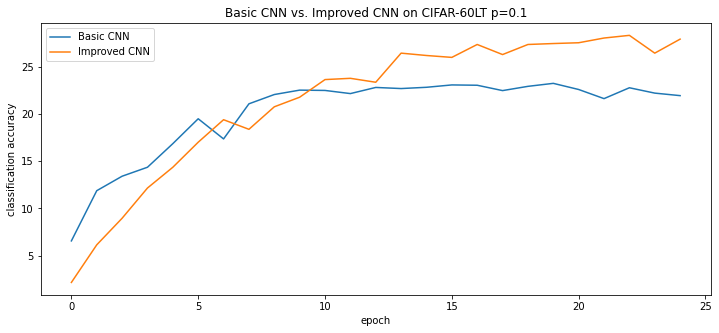

In [ ]:
fig, ax = plt.subplots(1, figsize = (12, 5))
ax.plot(basic_acc, label = "Basic CNN")
ax.plot(imp_acc, label = "Improved CNN")
ax.legend()
ax.set(ylabel = "classification accuracy", xlabel = "epoch")
ax.set_title("Basic CNN vs. Improved CNN on CIFAR-60LT p=0.1")
fig.savefig("/content/gdrive/My Drive/EE 443/Final/figs/basic_imp.png")

### Resampling Methods
Naive Random Oversampling

#### Dataset

In [ ]:
def get_cifar_oversampled(data_dir, json_name):
    dataset_dicts = [] # array with [[img, class]]
    class_count = np.zeros(60) # array of counts of each class
    cat2img = dict({}) # dictionary of class number to list of images in that class

    # class names
    classes = ['apple', 'baby', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'boy', 'bus', 'butterfly', 
                 'camel', 'can', 'caterpillar', 'cattle', 'chair', 'clock', 'cloud', 'cockroach', 'couch', 'crab',
                 'dinosaur', 'fox', 'lamp', 'lawn_mower', 'lobster', 'man', 'maple_tree', 'mouse', 'oak_tree', 'orange',
                 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plate', 'poppy', 'porcupine', 'possum',
                 'rabbit', 'ray', 'road', 'rocket', 'seal', 'shark', 'skunk', 'skyscraper', 'snake', 'spider', 'streetcar',
                 'table', 'telephone', 'television', 'tiger', 'turtle', 'whale', 'willow_tree', 'woman', 'worm']

    # open json file
    ann = json.load(open(os.path.join(data_dir, json_name)))['annotations']

    for a in ann:
        value = classes.index(a['category'])
        class_count[value] = class_count[value] + 1
        img = np.transpose((cv2.imread(os.path.join('cifar-data/', a['fpath']))), (2,0,1))
        record = [img, value]
        dataset_dicts.append(record)
        # add images to the dictionary categories to images
        if value in cat2img:
            imgs = cat2img[value]
            imgs.append(img)
            cat2img[value] = imgs
        else:
            cat2img[value] = [img]

    maximum = 500
    # for all the classes
    for i in range(60):
        diff = maximum - class_count[i] # calculate difference
        imgs = cat2img[i] # get the batch of images for that class
        for j in range(int(diff)): # for the length of the difference
            rand = np.random.randint(class_count[i]) # choose a random number between zero and the len of the class - 1
            dataset_dicts.append([imgs[rand], i]) # append data set with that random number    
    return dataset_dicts, class_count

In [ ]:
# p = 0.1 dataloader
dataroot = './cifar-data/cifar-100-data/converted60/cifar60_imbalance_0.1/'

train_osamp_1, cc1 = get_cifar_oversampled(dataroot, 'cifar60_imbalance_0.1_train.json')
train_osamp_loader_1 = torch.utils.data.DataLoader(train_osamp_1, batch_size=64, shuffle = True)

# p = 0.02 dataloader
dataroot = './cifar-data/cifar-100-data/converted60/cifar60_imbalance_0.02/'

train_osamp_02, cc2 = get_cifar_oversampled(dataroot, 'cifar60_imbalance_0.02_train.json')
train_osamp_loader_02 = torch.utils.data.DataLoader(train_osamp_02, batch_size=64, shuffle = True)

# p = 0.005 dataloader
dataroot = './cifar-data/cifar-100-data/converted60/cifar60_imbalance_0.005/'

train_osamp_005, cc3 = get_cifar_oversampled(dataroot, 'cifar60_imbalance_0.005_train.json')
train_osamp_loader_005 = torch.utils.data.DataLoader(train_osamp_005, batch_size=64, shuffle = True)

print("The length of the oversampled data set (500 images of 60 categories) is: {}".format(len(train_osamp_1))) # to check if there is the correct number of images in dataset

The length of the oversampled data set (500 images of 60 categories) is: 30000


#### Figure

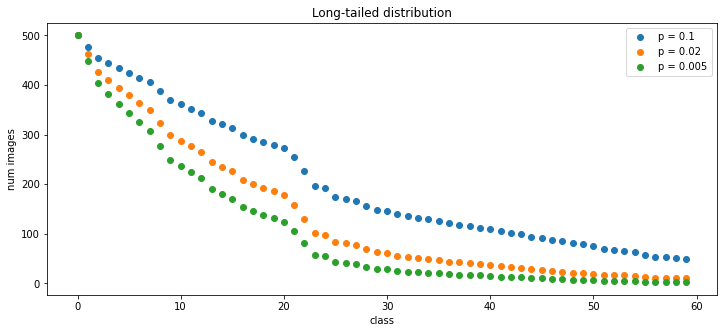

In [ ]:
n = range(60)
fig, ax = plt.subplots(1, figsize = (12, 5))
ax.scatter(n, cc1, label = 'p = 0.1')
ax.scatter(n, cc2, label = 'p = 0.02')
ax.scatter(n, cc3, label = 'p = 0.005')
ax.legend()
ax.set_title("Long-tailed distribution")
ax.set(ylabel = "num images", xlabel = "class")
fig.savefig("/content/gdrive/MyDrive/EE 443/Final/figs/fig1.png")

#### Evaluation

###### p = 0.1
Acc: 27.15%

In [ ]:
cnn_1 = CNN().to(device)

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_1.parameters(), lr=lr, momentum=0.9)

In [ ]:
n_epoch = 25
acc = 0

cnn_1.train()
for epoch in range(n_epoch):  # loop over the dataset multiple times
    for i, data in enumerate(train_osamp_loader_1, 0):
        input = data[0].to(device).float()
        label = data[1].to(device)
        optimizer.zero_grad()
        output = cnn_1(input)

        loss = criterion(output, label)
        loss.backward()

        optimizer.step()
        pass
    corr = 0
    num = 0
    cnn_1.eval()
    with torch.no_grad():
        for data in test_loader:
            input = data[0].to(device).float()
            target = data[1].to(device)
            target.shape
            output = cnn_1(input)
            output = output.argmax()

            if output == target[0]:
                corr += 1
            num += 1
            pass
    epoch_acc = corr/num*100
    print("Accuracy of the model (epoch {}) is: {}%".format(epoch, epoch_acc))
    if (epoch_acc > acc):
        acc = epoch_acc
        PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60_osamp_1.pth'
        torch.save(cnn_1.state_dict(), PATH)
    cnn_1.train()

Accuracy of the model (epoch 0) is: 10.666666666666668%
Accuracy of the model (epoch 1) is: 15.983333333333333%
Accuracy of the model (epoch 2) is: 18.816666666666666%
Accuracy of the model (epoch 3) is: 21.0%
Accuracy of the model (epoch 4) is: 23.916666666666668%
Accuracy of the model (epoch 5) is: 25.566666666666666%
Accuracy of the model (epoch 6) is: 24.233333333333334%
Accuracy of the model (epoch 7) is: 25.766666666666666%
Accuracy of the model (epoch 8) is: 26.150000000000002%
Accuracy of the model (epoch 9) is: 26.18333333333333%
Accuracy of the model (epoch 10) is: 25.516666666666666%
Accuracy of the model (epoch 11) is: 24.816666666666666%
Accuracy of the model (epoch 12) is: 25.666666666666664%
Accuracy of the model (epoch 13) is: 25.883333333333336%
Accuracy of the model (epoch 14) is: 26.416666666666664%
Accuracy of the model (epoch 15) is: 25.633333333333336%
Accuracy of the model (epoch 16) is: 26.766666666666666%
Accuracy of the model (epoch 17) is: 26.633333333333333%

In [ ]:
# loading best model
PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60_osamp_1.pth'
cnn_1 = CNN().to(device)
cnn_1.load_state_dict(torch.load(PATH))
print('Best model is stored at {} with accuracy: {}'.format(PATH, acc))

Best model is stored at /content/gdrive/My Drive/EE 443/Final/cifar60_osamp_1.pth with accuracy: 27.150000000000002


###### p = 0.02
Acc: 19.97%

In [ ]:
cnn_02 = CNN().to(device)

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_02.parameters(), lr=lr, momentum=0.9)

In [ ]:
n_epoch = 25
acc = 0

cnn_02.train()
for epoch in range(n_epoch):  # loop over the dataset multiple times
    for i, data in enumerate(train_osamp_loader_02, 0):
        input = data[0].to(device).float()
        label = data[1].to(device)
        optimizer.zero_grad()

        output = cnn_02(input)

        loss = criterion(output, label)
        loss.backward()

        optimizer.step()
        pass
    corr = 0
    num = 0
    cnn_02.eval()
    with torch.no_grad():
        for data in test_loader:
            input = data[0].to(device).float()
            target = data[1].to(device)

            output = cnn_02(input)
            output = output.argmax()

            if output == target[0]:
                corr += 1
            num += 1
            pass
    epoch_acc = corr/num*100
    print("Accuracy of the model (epoch {}) is: {}%".format(epoch, epoch_acc))
    if (epoch_acc > acc):
        acc = epoch_acc
        PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60_osamp_02.pth'
        torch.save(cnn_02.state_dict(), PATH)
    cnn_02.train()

Accuracy of the model (epoch 0) is: 8.116666666666667%
Accuracy of the model (epoch 1) is: 13.983333333333334%
Accuracy of the model (epoch 2) is: 16.166666666666664%
Accuracy of the model (epoch 3) is: 17.833333333333336%
Accuracy of the model (epoch 4) is: 19.183333333333334%
Accuracy of the model (epoch 5) is: 18.6%
Accuracy of the model (epoch 6) is: 19.55%
Accuracy of the model (epoch 7) is: 18.55%
Accuracy of the model (epoch 8) is: 19.01666666666667%
Accuracy of the model (epoch 9) is: 19.25%
Accuracy of the model (epoch 10) is: 19.21666666666667%
Accuracy of the model (epoch 11) is: 18.9%
Accuracy of the model (epoch 12) is: 18.5%
Accuracy of the model (epoch 13) is: 19.516666666666666%
Accuracy of the model (epoch 14) is: 19.28333333333333%
Accuracy of the model (epoch 15) is: 19.933333333333334%
Accuracy of the model (epoch 16) is: 17.8%
Accuracy of the model (epoch 17) is: 18.75%
Accuracy of the model (epoch 18) is: 19.966666666666665%
Accuracy of the model (epoch 19) is: 19

In [ ]:
# loading best model
PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60_osamp_02.pth'
cnn_02 = CNN().to(device)
cnn_02.load_state_dict(torch.load(PATH))
print('Best model is stored at {} with accuracy: {}'.format(PATH, acc))

Best model is stored at /content/gdrive/My Drive/EE 443/Final/cifar60_osamp_02.pth with accuracy: 19.966666666666665


###### p = 0.005
Acc: 16.92%

In [ ]:
cnn_005 = CNN().to(device)

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_005.parameters(), lr=lr, momentum=0.9)

In [ ]:
n_epoch = 25
acc = 0

cnn_005.train()
for epoch in range(n_epoch):  # loop over the dataset multiple times
    for i, data in enumerate(train_osamp_loader_005, 0):
        input = data[0].to(device).float()
        label = data[1].to(device)
        optimizer.zero_grad()

        output = cnn_005(input)

        loss = criterion(output, label)
        loss.backward()

        optimizer.step()
        pass
    corr = 0
    num = 0
    cnn_005.eval()
    with torch.no_grad():
        for data in test_loader:
            input = data[0].to(device).float()
            target = data[1].to(device)

            output = cnn_005(input)
            output = output.argmax()

            if output == target[0]:
                corr += 1
            num += 1
            pass
    epoch_acc = corr/num*100
    print("Accuracy of the model (epoch {}) is: {}%".format(epoch, epoch_acc))
    if (epoch_acc > acc):
        acc = epoch_acc
        PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60_osamp_005.pth'
        torch.save(cnn_005.state_dict(), PATH)
    cnn_005.train()

Accuracy of the model (epoch 0) is: 8.833333333333334%
Accuracy of the model (epoch 1) is: 14.283333333333333%
Accuracy of the model (epoch 2) is: 14.616666666666667%
Accuracy of the model (epoch 3) is: 14.95%
Accuracy of the model (epoch 4) is: 16.7%
Accuracy of the model (epoch 5) is: 15.166666666666668%
Accuracy of the model (epoch 6) is: 15.9%
Accuracy of the model (epoch 7) is: 15.7%
Accuracy of the model (epoch 8) is: 15.25%
Accuracy of the model (epoch 9) is: 16.083333333333332%
Accuracy of the model (epoch 10) is: 16.55%
Accuracy of the model (epoch 11) is: 15.55%
Accuracy of the model (epoch 12) is: 16.233333333333334%
Accuracy of the model (epoch 13) is: 15.916666666666668%
Accuracy of the model (epoch 14) is: 15.816666666666668%
Accuracy of the model (epoch 15) is: 16.383333333333333%
Accuracy of the model (epoch 16) is: 16.916666666666664%
Accuracy of the model (epoch 17) is: 16.616666666666667%
Accuracy of the model (epoch 18) is: 15.416666666666668%
Accuracy of the model 

In [ ]:
# loading best model
PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60_osamp_005.pth'
cnn_005 = CNN().to(device)
cnn_005.load_state_dict(torch.load(PATH))
print('Best model is stored at {} with accuracy: {}'.format(PATH, acc))

Best model is stored at /content/gdrive/My Drive/EE 443/Final/cifar60_osamp_005.pth with accuracy: 16.916666666666664


In [ ]:
utils.data.sampler.WeightedRandomSampler()

### Mixup Training

Mixup training is data augmentation where two images are mixed such that
$$\hat{x} = \lambda x_i + (1-\lambda)x_j$$ and $$\hat{y} = \lambda y_i + (1-\lambda)y_j$$

#### Defining the mixup dataset

In [ ]:
def get_cifar_mixup(data_dir, json_name):
    dataset_dicts = []

    classes = ['apple', 'baby', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'boy', 'bus', 'butterfly', 
                 'camel', 'can', 'caterpillar', 'cattle', 'chair', 'clock', 'cloud', 'cockroach', 'couch', 'crab',
                 'dinosaur', 'fox', 'lamp', 'lawn_mower', 'lobster', 'man', 'maple_tree', 'mouse', 'oak_tree', 'orange',
                 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plate', 'poppy', 'porcupine', 'possum',
                 'rabbit', 'ray', 'road', 'rocket', 'seal', 'shark', 'skunk', 'skyscraper', 'snake', 'spider', 'streetcar',
                 'table', 'telephone', 'television', 'tiger', 'turtle', 'whale', 'willow_tree', 'woman', 'worm']

    ann = json.load(open(os.path.join(data_dir, json_name)))['annotations']

    # mixup
    np.random.shuffle(ann) # so common classes are not right next to each other for mixup

    for i in range(0, len(ann), 2):
        lam = np.random.beta(1, 1)
        if (i+1 < len(ann)):
            valuex, valuey = classes.index(ann[i]['category']), classes.index(ann[i+1]['category'])
            imgx, imgy = np.transpose((cv2.imread(os.path.join('cifar-data/', ann[i]['fpath']))), (2,0,1)), np.transpose((cv2.imread(os.path.join('cifar-data/', ann[i+1]['fpath']))), (2,0,1))
            imgx, imgy = np.multiply(lam, imgx), np.multiply(1-lam, imgy) # lamda*x and (1-lambda*y)
            img = imgx + imgy
            img = img.astype('int16')
            val = np.zeros(60)
            val[valuex] = lam
            val[valuey] = 1-lam
            record = [img, val]
            dataset_dicts.append(record)
        else:
            value = classes.index(ann[i]['category'])
            val = np.zeros(60)
            val[value] = 1
            img = np.transpose((cv2.imread(os.path.join('cifar-data/', ann[i]['fpath']))), (2,0,1))
            record = [img, val]
            dataset_dicts.append(record)

    # also add non mixed images
    for a in ann:
        value = classes.index(a['category'])
        val = np.zeros(60)
        val[value] = 1
        img = np.transpose((cv2.imread(os.path.join('cifar-data/', a['fpath']))), (2,0,1))
        record = [img, val]
        dataset_dicts.append(record)
    return dataset_dicts

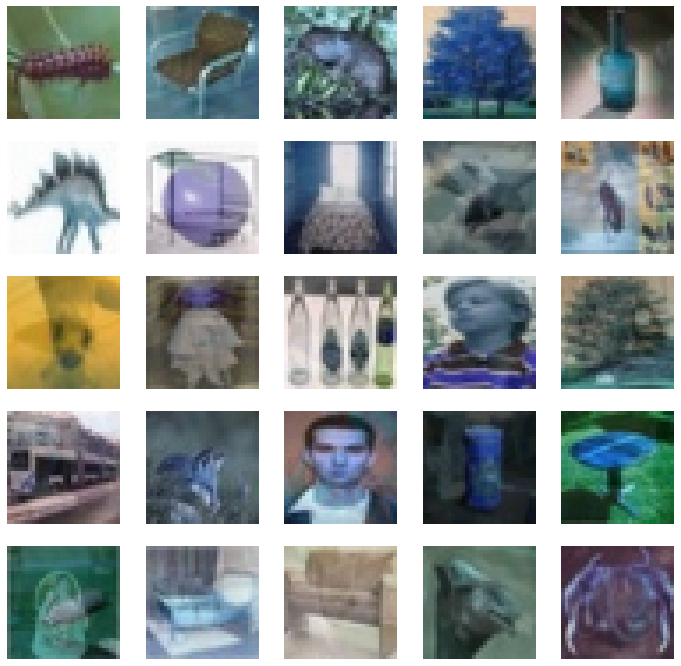

In [ ]:
# p = 0.1 dataloader
dataroot = './cifar-data/cifar-100-data/converted60/cifar60_imbalance_0.1/'

train_mixup_1 = get_cifar_mixup(dataroot, 'cifar60_imbalance_0.1_train.json')

train_mixup_loader_1 = torch.utils.data.DataLoader(train_mixup_1, batch_size=64, shuffle = True)

# p = 0.02 dataloader
dataroot = './cifar-data/cifar-100-data/converted60/cifar60_imbalance_0.02/'

train_mixup_02 = get_cifar_mixup(dataroot, 'cifar60_imbalance_0.02_train.json')

train_mixup_loader_02 = torch.utils.data.DataLoader(train_mixup_02, batch_size=64, shuffle = True)

# p = 0.005 dataloader
dataroot = './cifar-data/cifar-100-data/converted60/cifar60_imbalance_0.005/'

train_mixup_005 = get_cifar_mixup(dataroot, 'cifar60_imbalance_0.005_train.json')

train_mixup_loader_005 = torch.utils.data.DataLoader(train_mixup_005, batch_size=64, shuffle = True)

fig, axs = plt.subplots(5, 5, figsize = (12, 12))
for i, ax in enumerate(axs.flat):
#   ax.imshow(cv2.cvtColor(np.transpose(train_mixup_1[i][0],(1, 2, 0)), cv2.COLOR_BGR2RGB)) # coloring is weird due to data casting
  ax.imshow((np.transpose(train_mixup_1[i][0],(1, 2, 0))))
  ax.axis('off')
# fig.savefig("/content/gdrive/MyDrive/EE 443/Final/figs/mixup.png")

#### Evaluation

##### p = 0.1
Acc: 28.78%

In [ ]:
cnn_1 = CNN().to(device)

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_1.parameters(), lr=lr, momentum=0.9)

In [ ]:
n_epoch = 25
acc = 0

cnn_1.train()
for epoch in range(n_epoch):  # loop over the dataset multiple times
    for i, data in enumerate(train_mixup_loader_1, 0):
        input = data[0].to(device).float()
        label = data[1].to(device)
        optimizer.zero_grad()
        output = cnn_1(input)

        loss = criterion(output.float(), label.float())
        loss.backward()

        optimizer.step()
        pass
    corr = 0
    num = 0
    cnn_1.eval()
    with torch.no_grad():
        for data in test_loader:
            input = data[0].to(device).float()
            target = data[1].to(device)
            target.shape
            output = cnn_1(input)
            output = output.argmax()

            if output == target[0]:
                corr += 1
            num += 1
            pass
    epoch_acc = corr/num*100
    print("Accuracy of the model (epoch {}) is: {}%".format(epoch, epoch_acc))
    if (epoch_acc > acc):
        acc = epoch_acc
        PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60_mixup_1.pth'
        torch.save(cnn_1.state_dict(), PATH)
    cnn_1.train()

Accuracy of the model (epoch 0) is: 4.8500000000000005%
Accuracy of the model (epoch 1) is: 9.133333333333333%
Accuracy of the model (epoch 2) is: 13.366666666666665%
Accuracy of the model (epoch 3) is: 14.95%
Accuracy of the model (epoch 4) is: 19.400000000000002%
Accuracy of the model (epoch 5) is: 20.75%
Accuracy of the model (epoch 6) is: 22.883333333333333%
Accuracy of the model (epoch 7) is: 23.383333333333333%
Accuracy of the model (epoch 8) is: 26.18333333333333%
Accuracy of the model (epoch 9) is: 27.23333333333333%
Accuracy of the model (epoch 10) is: 27.750000000000004%
Accuracy of the model (epoch 11) is: 27.016666666666666%
Accuracy of the model (epoch 12) is: 27.583333333333332%
Accuracy of the model (epoch 13) is: 27.566666666666666%
Accuracy of the model (epoch 14) is: 28.499999999999996%
Accuracy of the model (epoch 15) is: 28.78333333333333%
Accuracy of the model (epoch 16) is: 28.28333333333333%
Accuracy of the model (epoch 17) is: 28.449999999999996%
Accuracy of the

In [ ]:
# loading best model
PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60_mixup_1.pth'
cnn_1 = CNN().to(device)
cnn_1.load_state_dict(torch.load(PATH))
print('Best model is stored at {} with accuracy: {}'.format(PATH, acc))

Best model is stored at /content/gdrive/My Drive/EE 443/Final/cifar60_mixup_1.pth with accuracy: 28.78333333333333


##### p = 0.02
Acc: 22.08%

In [ ]:
cnn_02 = CNN().to(device)

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_02.parameters(), lr=lr, momentum=0.9)

In [ ]:
n_epoch = 25
acc = 0

cnn_02.train()
for epoch in range(n_epoch):  # loop over the dataset multiple times
    for i, data in enumerate(train_mixup_loader_02, 0):
        input = data[0].to(device).float()
        label = data[1].to(device)
        optimizer.zero_grad()

        output = cnn_02(input)

        loss = criterion(output, label)
        loss.backward()

        optimizer.step()
        pass
    corr = 0
    num = 0
    cnn_02.eval()
    with torch.no_grad():
        for data in test_loader:
            input = data[0].to(device).float()
            target = data[1].to(device)

            output = cnn_02(input)
            output = output.argmax()

            if output == target[0]:
                corr += 1
            num += 1
            pass
    epoch_acc = corr/num*100
    print("Accuracy of the model (epoch {}) is: {}%".format(epoch, epoch_acc))
    if (epoch_acc > acc):
        acc = epoch_acc
        PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60_mixup_02.pth'
        torch.save(cnn_02.state_dict(), PATH)
    cnn_02.train()

Accuracy of the model (epoch 0) is: 2.8666666666666667%
Accuracy of the model (epoch 1) is: 5.533333333333333%
Accuracy of the model (epoch 2) is: 7.116666666666667%
Accuracy of the model (epoch 3) is: 9.233333333333334%
Accuracy of the model (epoch 4) is: 10.883333333333333%
Accuracy of the model (epoch 5) is: 14.233333333333334%
Accuracy of the model (epoch 6) is: 15.2%
Accuracy of the model (epoch 7) is: 17.150000000000002%
Accuracy of the model (epoch 8) is: 18.883333333333333%
Accuracy of the model (epoch 9) is: 17.9%
Accuracy of the model (epoch 10) is: 19.516666666666666%
Accuracy of the model (epoch 11) is: 19.466666666666665%
Accuracy of the model (epoch 12) is: 20.75%
Accuracy of the model (epoch 13) is: 19.7%
Accuracy of the model (epoch 14) is: 21.883333333333333%
Accuracy of the model (epoch 15) is: 20.4%
Accuracy of the model (epoch 16) is: 21.166666666666668%
Accuracy of the model (epoch 17) is: 20.333333333333332%
Accuracy of the model (epoch 18) is: 21.15%
Accuracy of 

In [ ]:
# loading best model
PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60_mixup_02.pth'
cnn_02 = CNN().to(device)
cnn_02.load_state_dict(torch.load(PATH))
print('Best model is stored at {} with accuracy: {}'.format(PATH, acc))

Best model is stored at /content/gdrive/My Drive/EE 443/Final/cifar60_mixup_02.pth with accuracy: 22.083333333333332


##### p = 0.005
Acc: 18.3%

In [ ]:
cnn_005 = CNN().to(device)

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_005.parameters(), lr=lr, momentum=0.9)

In [ ]:
n_epoch = 25
acc = 0

cnn_005.train()
for epoch in range(n_epoch):  # loop over the dataset multiple times
    for i, data in enumerate(train_mixup_loader_005, 0):
        input = data[0].to(device).float()
        label = data[1].to(device)
        optimizer.zero_grad()

        output = cnn_005(input)

        loss = criterion(output, label)
        loss.backward()

        optimizer.step()
        pass
    corr = 0
    num = 0
    cnn_005.eval()
    with torch.no_grad():
        for data in test_loader:
            input = data[0].to(device).float()
            target = data[1].to(device)

            output = cnn_005(input)
            output = output.argmax()

            if output == target[0]:
                corr += 1
            num += 1
            pass
    epoch_acc = corr/num*100
    print("Accuracy of the model (epoch {}) is: {}%".format(epoch, epoch_acc))
    if (epoch_acc > acc):
        acc = epoch_acc
        PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60_mixup_005.pth'
        torch.save(cnn_005.state_dict(), PATH)
    cnn_005.train()

Accuracy of the model (epoch 0) is: 1.6833333333333331%
Accuracy of the model (epoch 1) is: 4.566666666666666%
Accuracy of the model (epoch 2) is: 6.4%
Accuracy of the model (epoch 3) is: 8.116666666666667%
Accuracy of the model (epoch 4) is: 9.733333333333333%
Accuracy of the model (epoch 5) is: 10.016666666666667%
Accuracy of the model (epoch 6) is: 12.466666666666667%
Accuracy of the model (epoch 7) is: 13.750000000000002%
Accuracy of the model (epoch 8) is: 13.283333333333333%
Accuracy of the model (epoch 9) is: 14.549999999999999%
Accuracy of the model (epoch 10) is: 15.316666666666666%
Accuracy of the model (epoch 11) is: 15.816666666666668%
Accuracy of the model (epoch 12) is: 17.4%
Accuracy of the model (epoch 13) is: 17.333333333333336%
Accuracy of the model (epoch 14) is: 17.533333333333335%
Accuracy of the model (epoch 15) is: 17.033333333333335%
Accuracy of the model (epoch 16) is: 16.2%
Accuracy of the model (epoch 17) is: 17.549999999999997%
Accuracy of the model (epoch 1

In [ ]:
# loading best model
PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60_mixup_005.pth'
cnn_005 = CNN().to(device)
cnn_005.load_state_dict(torch.load(PATH))
print('Best model is stored at {} with accuracy: {}'.format(PATH, acc))

Best model is stored at /content/gdrive/My Drive/EE 443/Final/cifar60_mixup_005.pth with accuracy: 18.3


### Two-stage Training

#### Imbalanced training with balanced fine tuning.



##### p = 0.1
Acc: 30.47

In [ ]:
# loading best model
PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60_1.pth'
cnn_1 = CNN().to(device)
cnn_1.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_1.parameters(), lr=lr, momentum=0.9)

In [ ]:
n_epoch = 25
acc = 0
imp_ft_acc = []

cnn_1.train()
for epoch in range(n_epoch):  # loop over the dataset multiple times
    for i, data in enumerate(train_osamp_loader_1, 0):
        input = data[0].to(device).float()
        label = data[1].to(device)
        optimizer.zero_grad()
        output = cnn_1(input)

        loss = criterion(output, label)
        loss.backward()

        optimizer.step()
        pass
    corr = 0
    num = 0
    cnn_1.eval()
    with torch.no_grad():
        for data in test_loader:
            input = data[0].to(device).float()
            target = data[1].to(device)
            target.shape
            output = cnn_1(input)
            output = output.argmax()

            if output == target[0]:
                corr += 1
            num += 1
            pass
    epoch_acc = corr/num*100
    imp_ft_acc.append(epoch_acc)
    print("Accuracy of the model (epoch {}) is: {}%".format(epoch, epoch_acc))
    if (epoch_acc > acc):
        acc = epoch_acc
        PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60_imbalance+ft_1.pth'
        torch.save(cnn_1.state_dict(), PATH)
    cnn_1.train()

Accuracy of the model (epoch 0) is: 28.76666666666667%
Accuracy of the model (epoch 1) is: 27.750000000000004%
Accuracy of the model (epoch 2) is: 28.616666666666667%
Accuracy of the model (epoch 3) is: 28.249999999999996%
Accuracy of the model (epoch 4) is: 28.583333333333332%
Accuracy of the model (epoch 5) is: 28.599999999999998%
Accuracy of the model (epoch 6) is: 28.549999999999997%
Accuracy of the model (epoch 7) is: 28.566666666666666%
Accuracy of the model (epoch 8) is: 29.049999999999997%
Accuracy of the model (epoch 9) is: 28.866666666666667%
Accuracy of the model (epoch 10) is: 30.233333333333334%
Accuracy of the model (epoch 11) is: 30.2%
Accuracy of the model (epoch 12) is: 29.833333333333336%
Accuracy of the model (epoch 13) is: 30.099999999999998%
Accuracy of the model (epoch 14) is: 29.633333333333333%
Accuracy of the model (epoch 15) is: 29.549999999999997%
Accuracy of the model (epoch 16) is: 29.849999999999998%
Accuracy of the model (epoch 17) is: 29.2%
Accuracy of t

In [ ]:
# loading best model
PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60_imbalance+ft_1.pth'
cnn_1 = CNN().to(device)
cnn_1.load_state_dict(torch.load(PATH))
print('Best model is stored at {} with accuracy: {}'.format(PATH, acc))

Best model is stored at /content/gdrive/My Drive/EE 443/Final/cifar60_imbalance+ft_1.pth with accuracy: 30.466666666666665


##### p = 0.02
Acc: 23.77

In [ ]:
# loading best model
PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60_02.pth'
cnn_02 = CNN().to(device)
cnn_02.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_02.parameters(), lr=lr, momentum=0.9)

In [ ]:
n_epoch = 25
acc = 0

cnn_02.train()
for epoch in range(n_epoch):  # loop over the dataset multiple times
    for i, data in enumerate(train_osamp_loader_02, 0):
        input = data[0].to(device).float()
        label = data[1].to(device)
        optimizer.zero_grad()
        output = cnn_02(input)

        loss = criterion(output, label)
        loss.backward()

        optimizer.step()
        pass
    corr = 0
    num = 0
    cnn_02.eval()
    with torch.no_grad():
        for data in test_loader:
            input = data[0].to(device).float()
            target = data[1].to(device)
            target.shape
            output = cnn_02(input)
            output = output.argmax()

            if output == target[0]:
                corr += 1
            num += 1
            pass
    epoch_acc = corr/num*100
    print("Accuracy of the model (epoch {}) is: {}%".format(epoch, epoch_acc))
    if (epoch_acc > acc):
        acc = epoch_acc
        PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60_imbalance+ft_02.pth'
        torch.save(cnn_02.state_dict(), PATH)
    cnn_02.train()

Accuracy of the model (epoch 0) is: 22.366666666666667%
Accuracy of the model (epoch 1) is: 22.483333333333334%
Accuracy of the model (epoch 2) is: 22.03333333333333%
Accuracy of the model (epoch 3) is: 22.75%
Accuracy of the model (epoch 4) is: 22.433333333333334%
Accuracy of the model (epoch 5) is: 22.01666666666667%
Accuracy of the model (epoch 6) is: 22.316666666666666%
Accuracy of the model (epoch 7) is: 22.3%
Accuracy of the model (epoch 8) is: 22.75%
Accuracy of the model (epoch 9) is: 22.816666666666666%
Accuracy of the model (epoch 10) is: 22.2%
Accuracy of the model (epoch 11) is: 22.53333333333333%
Accuracy of the model (epoch 12) is: 22.25%
Accuracy of the model (epoch 13) is: 23.033333333333335%
Accuracy of the model (epoch 14) is: 22.966666666666665%
Accuracy of the model (epoch 15) is: 23.233333333333334%
Accuracy of the model (epoch 16) is: 22.78333333333333%
Accuracy of the model (epoch 17) is: 23.016666666666666%
Accuracy of the model (epoch 18) is: 23.383333333333333

In [ ]:
# loading best model
PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60_imbalance+ft_02.pth'
cnn_02 = CNN().to(device)
cnn_02.load_state_dict(torch.load(PATH))
print('Best model is stored at {} with accuracy: {}'.format(PATH, acc))

Best model is stored at /content/gdrive/My Drive/EE 443/Final/cifar60_imbalance+ft_02.pth with accuracy: 23.766666666666666


##### p = 0.005
Acc: 21.13

In [ ]:
# loading best model
PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60_005.pth'
cnn_005 = CNN().to(device)
cnn_005.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_005.parameters(), lr=lr, momentum=0.9)

In [ ]:
n_epoch = 25
acc = 0

cnn_005.train()
for epoch in range(n_epoch):  # loop over the dataset multiple times
    for i, data in enumerate(train_osamp_loader_005, 0):
        input = data[0].to(device).float()
        label = data[1].to(device)
        optimizer.zero_grad()
        output = cnn_005(input)

        loss = criterion(output, label)
        loss.backward()

        optimizer.step()
        pass
    corr = 0
    num = 0
    cnn_005.eval()
    with torch.no_grad():
        for data in test_loader:
            input = data[0].to(device).float()
            target = data[1].to(device)
            target.shape
            output = cnn_005(input)
            output = output.argmax()

            if output == target[0]:
                corr += 1
            num += 1
            pass
    epoch_acc = corr/num*100
    print("Accuracy of the model (epoch {}) is: {}%".format(epoch, epoch_acc))
    if (epoch_acc > acc):
        acc = epoch_acc
        PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60_imbalance+ft_005.pth'
        torch.save(cnn_005.state_dict(), PATH)
    cnn_005.train()

Accuracy of the model (epoch 0) is: 20.7%
Accuracy of the model (epoch 1) is: 20.433333333333334%
Accuracy of the model (epoch 2) is: 20.033333333333335%
Accuracy of the model (epoch 3) is: 19.7%
Accuracy of the model (epoch 4) is: 20.416666666666668%
Accuracy of the model (epoch 5) is: 20.616666666666667%
Accuracy of the model (epoch 6) is: 21.133333333333333%
Accuracy of the model (epoch 7) is: 20.599999999999998%
Accuracy of the model (epoch 8) is: 19.433333333333334%
Accuracy of the model (epoch 9) is: 20.033333333333335%
Accuracy of the model (epoch 10) is: 20.083333333333332%
Accuracy of the model (epoch 11) is: 19.45%
Accuracy of the model (epoch 12) is: 20.65%
Accuracy of the model (epoch 13) is: 19.483333333333334%
Accuracy of the model (epoch 14) is: 20.849999999999998%
Accuracy of the model (epoch 15) is: 20.166666666666664%
Accuracy of the model (epoch 16) is: 20.8%
Accuracy of the model (epoch 17) is: 20.65%
Accuracy of the model (epoch 18) is: 20.183333333333334%
Accuracy

In [ ]:
# loading best model
PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60_imbalance+ft_005.pth'
cnn_005 = CNN().to(device)
cnn_005.load_state_dict(torch.load(PATH))
print('Best model is stored at {} with accuracy: {}'.format(PATH, acc))

Best model is stored at /content/gdrive/My Drive/EE 443/Final/cifar60_imbalance+ft_005.pth with accuracy: 21.133333333333333


##### Figure

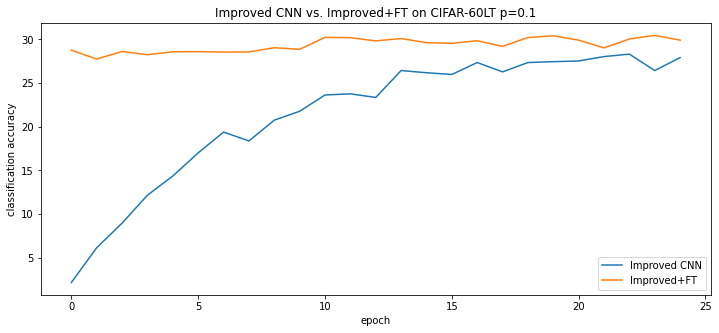

In [ ]:
fig, ax = plt.subplots(1, figsize = (12, 5))
ax.plot(imp_acc, label = "Improved CNN")
ax.plot(imp_ft_acc, label = "Improved+FT")
ax.legend()
ax.set(ylabel = "classification accuracy", xlabel = "epoch")
ax.set_title("Improved CNN vs. Improved+FT on CIFAR-60LT p=0.1")
fig.savefig("/content/gdrive/My Drive/EE 443/Final/figs/ft_imp.png")

#### Mixup training with fine tuning


##### p = 0.1
Acc:30.58

In [ ]:
# loading best model
PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60_mixup_1.pth'
cnn_1 = CNN().to(device)
cnn_1.load_state_dict(torch.load(PATH))

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_1.parameters(), lr=lr, momentum=0.9)

In [ ]:
n_epoch = 25
acc = 0
mix_ft_acc = []

cnn_1.train()
for epoch in range(n_epoch):  # loop over the dataset multiple times
    for i, data in enumerate(train_osamp_loader_1, 0):
        input = data[0].to(device).float()
        label = data[1].to(device)
        optimizer.zero_grad()
        output = cnn_1(input)

        loss = criterion(output, label)
        loss.backward()

        optimizer.step()
        pass
    corr = 0
    num = 0
    cnn_1.eval()
    with torch.no_grad():
        for data in test_loader:
            input = data[0].to(device).float()
            target = data[1].to(device)
            target.shape
            output = cnn_1(input)
            output = output.argmax()

            if output == target[0]:
                corr += 1
            num += 1
            pass
    epoch_acc = corr/num*100
    mix_ft_acc.append(epoch_acc)
    print("Accuracy of the model (epoch {}) is: {}%".format(epoch, epoch_acc))
    if (epoch_acc > acc):
        acc = epoch_acc
        PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60_mixup+ft_1.pth'
        torch.save(cnn_1.state_dict(), PATH)
    cnn_1.train()

Accuracy of the model (epoch 0) is: 28.183333333333334%
Accuracy of the model (epoch 1) is: 28.183333333333334%
Accuracy of the model (epoch 2) is: 28.28333333333333%
Accuracy of the model (epoch 3) is: 28.96666666666667%
Accuracy of the model (epoch 4) is: 29.46666666666667%
Accuracy of the model (epoch 5) is: 28.76666666666667%
Accuracy of the model (epoch 6) is: 29.283333333333335%
Accuracy of the model (epoch 7) is: 29.433333333333334%
Accuracy of the model (epoch 8) is: 29.683333333333334%
Accuracy of the model (epoch 9) is: 29.71666666666667%
Accuracy of the model (epoch 10) is: 30.483333333333334%
Accuracy of the model (epoch 11) is: 29.65%
Accuracy of the model (epoch 12) is: 29.65%
Accuracy of the model (epoch 13) is: 30.083333333333336%
Accuracy of the model (epoch 14) is: 29.233333333333334%
Accuracy of the model (epoch 15) is: 29.683333333333334%
Accuracy of the model (epoch 16) is: 29.666666666666668%
Accuracy of the model (epoch 17) is: 29.933333333333334%
Accuracy of the

In [ ]:
# loading best model
PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60_mixup+ft_1.pth'
cnn_1 = CNN().to(device)
cnn_1.load_state_dict(torch.load(PATH))
print('Best model is stored at {} with accuracy: {}'.format(PATH, acc))

Best model is stored at /content/gdrive/My Drive/EE 443/Final/cifar60_mixup+ft_1.pth with accuracy: 30.583333333333336


##### p = 0.02
Acc: 23.62

In [ ]:
# loading best model
PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60_mixup_02.pth'
cnn_02 = CNN().to(device)
cnn_02.load_state_dict(torch.load(PATH))

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_02.parameters(), lr=lr, momentum=0.9)

In [ ]:
n_epoch = 25
acc = 0

cnn_02.train()
for epoch in range(n_epoch):  # loop over the dataset multiple times
    for i, data in enumerate(train_osamp_loader_02, 0):
        input = data[0].to(device).float()
        label = data[1].to(device)
        optimizer.zero_grad()
        output = cnn_02(input)

        loss = criterion(output, label)
        loss.backward()

        optimizer.step()
        pass
    corr = 0
    num = 0
    cnn_02.eval()
    with torch.no_grad():
        for data in test_loader:
            input = data[0].to(device).float()
            target = data[1].to(device)
            target.shape
            output = cnn_02(input)
            output = output.argmax()

            if output == target[0]:
                corr += 1
            num += 1
            pass
    epoch_acc = corr/num*100
    print("Accuracy of the model (epoch {}) is: {}%".format(epoch, epoch_acc))
    if (epoch_acc > acc):
        acc = epoch_acc
        PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60_mixup+ft_02.pth'
        torch.save(cnn_02.state_dict(), PATH)
    cnn_02.train()

Accuracy of the model (epoch 0) is: 23.150000000000002%
Accuracy of the model (epoch 1) is: 21.933333333333334%
Accuracy of the model (epoch 2) is: 21.883333333333333%
Accuracy of the model (epoch 3) is: 22.433333333333334%
Accuracy of the model (epoch 4) is: 21.78333333333333%
Accuracy of the model (epoch 5) is: 22.433333333333334%
Accuracy of the model (epoch 6) is: 22.416666666666664%
Accuracy of the model (epoch 7) is: 21.71666666666667%
Accuracy of the model (epoch 8) is: 21.633333333333333%
Accuracy of the model (epoch 9) is: 23.266666666666666%
Accuracy of the model (epoch 10) is: 22.316666666666666%
Accuracy of the model (epoch 11) is: 22.26666666666667%
Accuracy of the model (epoch 12) is: 21.85%
Accuracy of the model (epoch 13) is: 22.083333333333332%
Accuracy of the model (epoch 14) is: 22.583333333333332%
Accuracy of the model (epoch 15) is: 21.233333333333334%
Accuracy of the model (epoch 16) is: 23.35%
Accuracy of the model (epoch 17) is: 22.166666666666668%
Accuracy of t

In [ ]:
# loading best model
PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60_mixup+ft_02.pth'
cnn_02 = CNN().to(device)
cnn_02.load_state_dict(torch.load(PATH))
print('Best model is stored at {} with accuracy: {}'.format(PATH, acc))

Best model is stored at /content/gdrive/My Drive/EE 443/Final/cifar60_mixup+ft_02.pth with accuracy: 23.616666666666667


##### p = 0.005
Acc: 20.1

In [ ]:
# loading best model
PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60_mixup_005.pth'
cnn_005 = CNN().to(device)
cnn_005.load_state_dict(torch.load(PATH))

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_005.parameters(), lr=lr, momentum=0.9)

In [ ]:
n_epoch = 25
acc = 0

cnn_005.train()
for epoch in range(n_epoch):  # loop over the dataset multiple times
    for i, data in enumerate(train_osamp_loader_005, 0):
        input = data[0].to(device).float()
        label = data[1].to(device)
        optimizer.zero_grad()
        output = cnn_005(input)

        loss = criterion(output, label)
        loss.backward()

        optimizer.step()
        pass
    corr = 0
    num = 0
    cnn_005.eval()
    with torch.no_grad():
        for data in test_loader:
            input = data[0].to(device).float()
            target = data[1].to(device)
            target.shape
            output = cnn_005(input)
            output = output.argmax()

            if output == target[0]:
                corr += 1
            num += 1
            pass
    epoch_acc = corr/num*100
    print("Accuracy of the model (epoch {}) is: {}%".format(epoch, epoch_acc))
    if (epoch_acc > acc):
        acc = epoch_acc
        PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60_mixup+ft_005.pth'
        torch.save(cnn_005.state_dict(), PATH)
    cnn_005.train()

Accuracy of the model (epoch 0) is: 19.233333333333334%
Accuracy of the model (epoch 1) is: 19.416666666666664%
Accuracy of the model (epoch 2) is: 18.516666666666666%
Accuracy of the model (epoch 3) is: 19.116666666666667%
Accuracy of the model (epoch 4) is: 18.583333333333332%
Accuracy of the model (epoch 5) is: 19.5%
Accuracy of the model (epoch 6) is: 19.15%
Accuracy of the model (epoch 7) is: 19.45%
Accuracy of the model (epoch 8) is: 19.366666666666667%
Accuracy of the model (epoch 9) is: 19.183333333333334%
Accuracy of the model (epoch 10) is: 19.7%
Accuracy of the model (epoch 11) is: 18.78333333333333%
Accuracy of the model (epoch 12) is: 19.35%
Accuracy of the model (epoch 13) is: 18.166666666666668%
Accuracy of the model (epoch 14) is: 19.566666666666666%
Accuracy of the model (epoch 15) is: 19.25%
Accuracy of the model (epoch 16) is: 19.03333333333333%
Accuracy of the model (epoch 17) is: 20.1%
Accuracy of the model (epoch 18) is: 19.366666666666667%
Accuracy of the model (

In [ ]:
# loading best model
PATH = '/content/gdrive/My Drive/EE 443/Final/cifar60_mixup+ft_005.pth'
cnn_005 = CNN().to(device)
cnn_005.load_state_dict(torch.load(PATH))
print('Best model is stored at {} with accuracy: {}'.format(PATH, acc))

Best model is stored at /content/gdrive/My Drive/EE 443/Final/cifar60_mixup+ft_005.pth with accuracy: 20.1


##### Figure

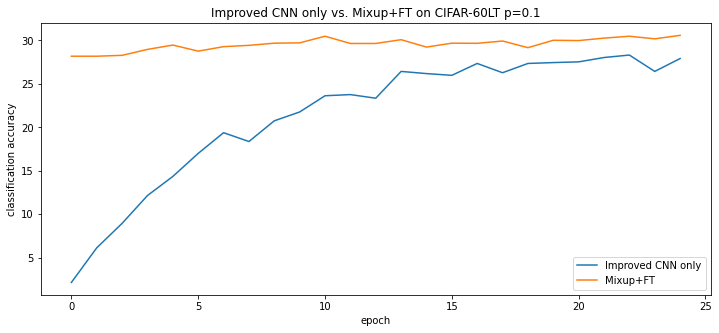

In [ ]:
fig, ax = plt.subplots(1, figsize = (12, 5))
ax.plot(imp_acc, label = "Improved CNN only")
ax.plot(mix_ft_acc, label = "Mixup+FT")
ax.legend()
ax.set(ylabel = "classification accuracy", xlabel = "epoch")
ax.set_title("Improved CNN only vs. Mixup+FT on CIFAR-60LT p=0.1")
fig.savefig("/content/gdrive/My Drive/EE 443/Final/figs/mixup_imp.png")